# Walkthrough

This notebook follows an example trackpy project from start to finish. We take video of micron-sized particles diffusing in water, track them, and analyze the trajectories to obtain the viscosity of water.

At the bottom of the notebook, we very briefly survey the more advanced features of trackpy. Browse the [rest of the documentation](https://soft-matter.github.io/trackpy/stable) to learn more.

## Scientific IPython Setup

We need Python's plotting library, matplotlib. Your environment might load matplotlib automatically, but for this tutorial I'll load it explicitly using this convention. If you are unfamiliar with matplotlib, do the same as I do here, and everything that follows will work without modification.

In [26]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# the following line only works in an IPython notebook

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

We also might want to use scientific Python libraries. Finally, we'll import ``trackpy`` itself and its sister project, `pims`.

In [27]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

We use the alias ``tp`` for brevity.

## Step 1: Read the Data

### Opening images or video

To get our data into Python, we use our sister project, [PIMS](https://github.com/soft-matter/pims) (Python Image Sequence). PIMS makes it easy and convenient to load and process video data from many formats with one consistent interface.

Using PIMS, trackpy can read:
* a directory or zipfile of sequential images
* a multi-frame TIFF file
* a video (AVI, MOV, etc.)
* specialty formats used in microscopy and scientific video capture:
    * `Cine`, NorPix `seq`
    * `LSM`
    * Files supported by [Bioformats](https://www.openmicroscopy.org/site/support/bio-formats5.1/supported-formats.html)
    * `ND2` using [PIMS_ND2](https://github.com/soft-matter/pims_nd2)

(Some of the formats require some extra dependencies. For a complete list, see the [README page](https://github.com/soft-matter/pims) for PIMS, or the installation instructions in the documentation.)

For many formats, using `pims.open` just works. Since these images are in color, we also need to set up a *pipeline* to convert each image to grayscale when it is read.

In [28]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = gray(pims.open('../sample_data/test/*.png'))


In [29]:
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: h:\learning\project\Tracking\sample_data\test\*.png
    Length: 991 frames
    Frame Shape: (764, 308, 3)
    Pixel Datatype: uint8

We can access any frame like `frames[frame_number]`. The image is represented as a numpy array of intensities. If you're using the [Anaconda distribution](https://www.anaconda.com/distribution/) of Python, these should be in the range [0, 255]. If you have a more custom environment they may be in the range [0, 1], in which case you'll have to experiment with the `minmass` parameters below.

In [30]:
print(frames[0])  # the first frame

[[27 23 20 ...  5 12 12]
 [26 26 21 ...  5 12 12]
 [26 26 24 ...  5 12 13]
 ...
 [ 0  0  0 ... 18 56 70]
 [ 0  0  0 ... 16 55 70]
 [ 0  0  0 ... 16 55 72]]


In an IPython notebook, the frame is represented directly by displaying the image.

Frame([[27, 23, 20, ...,  5, 12, 12],
       [26, 26, 21, ...,  5, 12, 12],
       [26, 26, 24, ...,  5, 12, 13],
       ...,
       [ 0,  0,  0, ..., 18, 56, 70],
       [ 0,  0,  0, ..., 16, 55, 70],
       [ 0,  0,  0, ..., 16, 55, 72]], dtype=uint8)
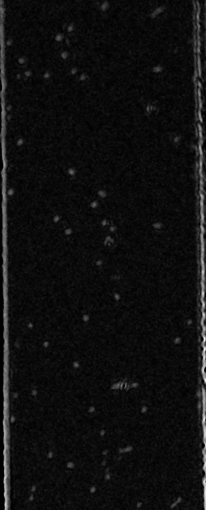

In [31]:
frames[0]

Alternatively, to make a proper plot with axes and control over scaling, use matplotlib's `imshow()` method.

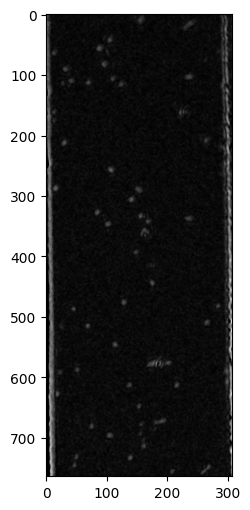

In [32]:
plt.imshow(frames[0]);

Frames behave like numpy arrays, but with a few extra properties.

In [33]:
frames[123].frame_no

123

In [34]:
frames[123].metadata  # Scientific formats can pass experiment meta data here.

{}

## Step 2: Locate Features

Start with just the first frame. Estimate the size of the features (in pixels). The size must be an odd integer, and it is better to err on the large side, as we'll see below. We estimate 11 pixels.

In [35]:
f = tp.locate(frames[0], 33, invert=False)

The algorithm looks for *bright* features; since the features in this set of images are dark, we set ``invert=True``.

``locate`` returns a spreadsheet-like object called a DataFrame. It lists 

* each feature's position,
* various characterizations of its appearance, which we will use to filter out spurious features,
* the "signal" strength and an estimate of uncertainty, both derived from [this paper](https://doi.org/10.1529/biophysj.104.042457)

More information about DataFrames may be found in the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#pandas.DataFrame). DataFrames can easily be exported to formats like CSV, Excel, SQL, HDF5, etc.

In [36]:
f.head()  # shows the first few rows of data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,28.404499,29.455966,512.034526,9.835165,0.235465,3.318562,2469.0,NaN,0
1,46.108392,186.093531,446.639342,10.135878,0.162481,3.123352,2225.0,NaN,0
2,56.353297,89.249527,1548.206567,6.540130,0.142219,21.082626,4663.0,NaN,0
3,77.537829,200.503111,972.728952,10.537606,0.126145,5.465866,2764.0,NaN,0
4,90.065868,32.486912,1140.999544,4.965803,0.041693,17.568855,3823.0,NaN,0


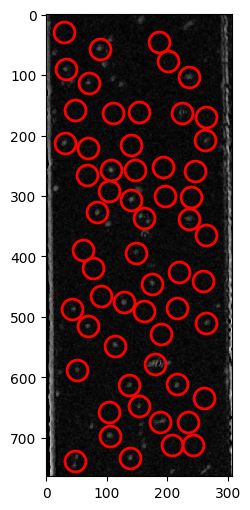

In [37]:
tp.annotate(f, frames[0]);

### Refine parameters to elminate spurious features
Many of these circles are clearly wrong; they are fleeting peaks in brightness that aren't actually particles. Rejecting them often improves results and speeds up feature-finding. There are many ways to distinguish real particles from spurious ones. The most important way is to look at total brightness ("mass").

Text(875.5419493851252, 5.0, '5.0')

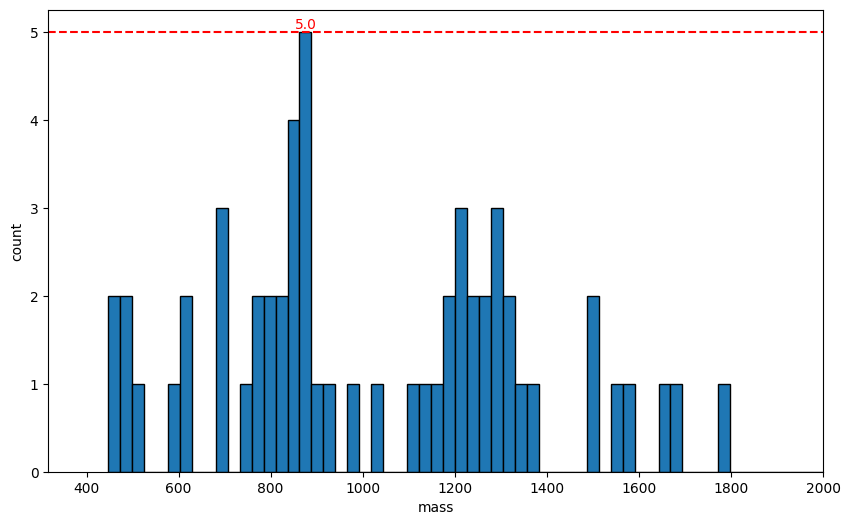

In [38]:
fig, ax = plt.subplots()
counts,bins,_=ax.hist(f['mass'], bins=100,edgecolor="black")
max_count=np.max(counts)
max_index = np.argmax(counts)
# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');
ax.set_xlim(xmax=2000)
plt.axhline(y=max_count, color='red', linestyle='--', label='Max Count: {}'.format(max_count))
plt.text(bins[max_index] + (bins[1] - bins[0]) / 2, max_count, str(max_count),
         ha='center', va='bottom', color='red')


We can then specify the `minmass` parameter. If your image is especially noisy, you may also find the `threshold` parameter  useful.

In [73]:
f = tp.locate(frames[0], 31, invert=False, minmass=400)

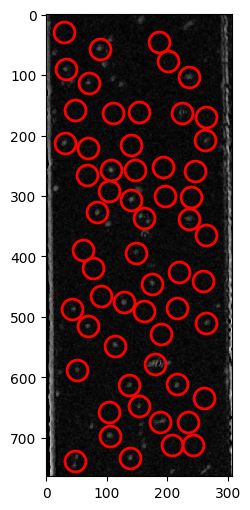

In [72]:
tp.annotate(f, frames[0]);

There are more options for controling and optimizing feature-finding. You can review them in the [documentation](https://soft-matter.github.io/trackpy/stable/), where the most comprehensive description is in the API reference. Or, pull them up as you work by typing ``tp.locate?`` into IPython.

### Check for subpixel accuracy
As Eric Weeks points out in his related tutorial, a quick way to check for subpixel accuracy is to check that the decimal part of the x and/or y positions are evenly distributed. Trackpy provides a convenience plotting function for this called `subpx_bias`:

h:\learning\project\tracking\trackpy\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

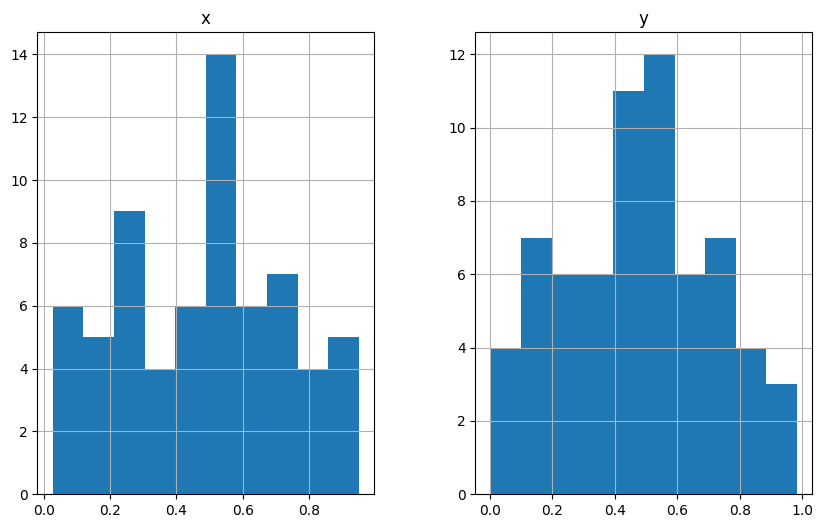

In [75]:
tp.subpx_bias(f)

### Locate features in all frames
Or, to start, just explore a subset of the frames.

 selection | syntax example
 --------- | --------------
 all the frames | `frames[:]` or simply `frames`.
 the first 10 frames | `frames[:10]`
 the last 10 frames | `frames[-10:]`
 a range of frames | `frames[100:200]`
 every 10th frame | `frame[::10]`
 a list of specific frames | `frames[[100, 107, 113]]`

We'll locate features in the first 300 frames from this video. We use ``tp.batch``, which calls ``tp.locate`` on each frame and collects the results.

In [76]:
f = tp.batch(frames[:], 31, minmass=400, invert=False);

Frame 990: 60 features


As each frame is analyzed, `tp.batch` reports the frame number and how many features were found. If this number runs unexpectedly low or high, you may wish to interrupt it and try different parameters. 

If your images are small, you may find that printing this number actually slows down `batch` significantly! In that case you can run `tp.quiet()` to turn it off.

## Step 3: Link features into particle trajectories
We have the locations of the particles in each frame. Next we'll track particles from frame to frame, giving each one a number for identification.

First, we must must specify a maximum displacement, the farthest a particle can travel between frames. We should choose the smallest reasonable value because a large value slows computation time considerably. In this case, 5 pixels is reasonable.

Second, we allow for the possibility that a particle might be missed for a few frames and then seen again. (Perhaps its "mass" slipped below our cutoff due to noise in the video.) Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance. Here we use 3 frames.

In [77]:
# tp.quiet()  # Turn off progress reports for best performance
t = tp.link(f, 15, memory=4)

Frame 990: 60 trajectories present.


The result is the features DataFrame `f` with an additional column, `particle`, identifying each feature with a label. We denote this new DataFrame `t`.

In [78]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,17.150093,234.832562,1688.171780,7.490064,0.453117,13.469456,4640.0,NaN,0,0
35,393.512032,148.538990,1078.922922,6.841243,0.061101,15.031132,3502.0,NaN,0,1
36,426.297156,245.458084,782.399687,10.058648,0.224628,3.708981,2560.0,NaN,0,2
37,419.695878,76.484848,715.052409,10.004681,0.118725,4.685028,2391.0,NaN,0,3
38,444.542989,173.936029,1144.318105,5.505464,0.194454,22.058674,3664.0,NaN,0,4


### Filter spurious trajectories

We have more filtering to do. Ephemeral trajectories — seen only for a few frames — are usually spurious and never useful. The convenience function `filter_stubs` keeps only trajectories that last for a given number of frames.

In [79]:
t1 = tp.filter_stubs(t, 50)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 12019
After: 59


We can also filter trajectories by their particles' appearance. At this stage, with trajectories linked, we can look at a feature's "average appearance" throughout its trajectory, giving a more accurate picture.

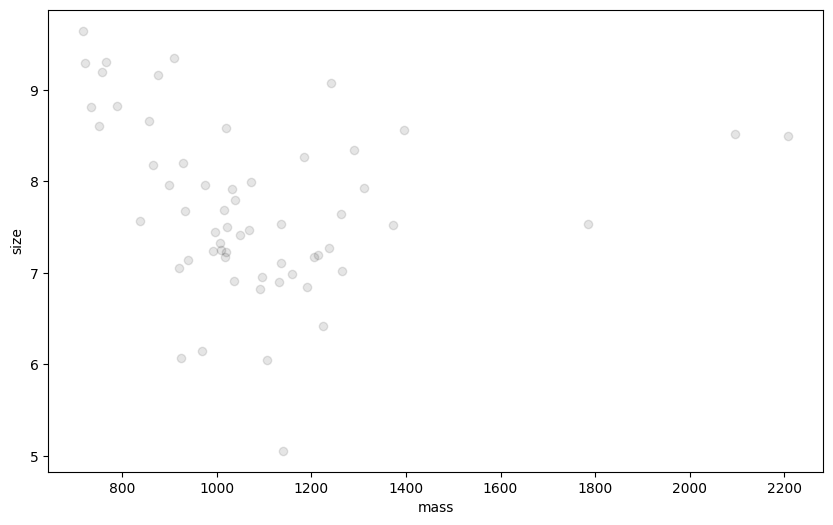

In [80]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

The particles with especially low mass, or that are especially large or non-circular (eccentric), are probably out of focus or aggregated, respectively. It is best to experiment by trial and error, filtering out regions of mass-size space and looking at the results using `tp.annotate`. In the end, we need to separate the good particles from the spurious ones, and it doesn't matter how we get it done.

In [81]:
condition = lambda x: (3000>(x['mass'].mean() >700) & (x['size'].mean() < 100))
t2 = tp.filter(t1, condition)  # a wrapper for pandas' filter that works around a bug in v 0.12

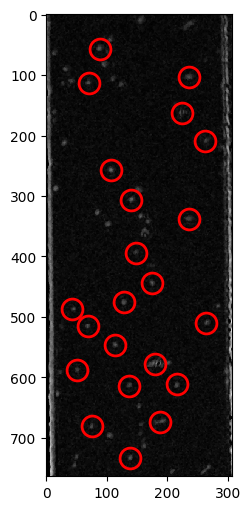

In [82]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0]);

Trace the trajectories using `plot_traj()`:

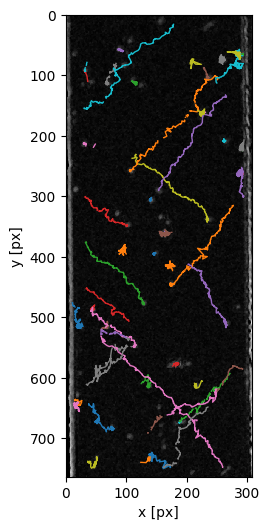

59

In [83]:
plt.figure()
tp.plot_traj(t2,superimpose=frames[0]);
len(set(t2["particle"]))

#t2.to_csv("result.csv")



**This is the end of the walkthrough. Keep reading to review a few more advanced capabilities in trackpy.**

# Preview of Some Advanced Features

**Check out the other tutorials for in-depth explorations of these topics and more!**